In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
from qiskit import Aer
from qiskit import transpile
from qiskit.visualization import plot_histogram

from iminuit import Minuit 
import sys 

In [2]:
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax 
from ExternalFunctions import bin_and_fit_gauss

In [3]:
def make_Q(A):
    frob_norm = np.linalg.norm(A, 'fro') 
    m = len(A)
    n = len(A[0])
    
    B = np.zeros(((m*n),n))
    
    matrix_list = []
    for count, value in enumerate(A, start = 0):
        f_norm = np.linalg.norm(value)
        diag_vec = np.full((n), f_norm)
        diag_matrix = np.diag(diag_vec, 0)
        matrix_list.append(diag_matrix)
    
    Q = np.concatenate(matrix_list)
    Q_norm = Q/frob_norm
    return Q_norm

In [4]:
def make_P(A):
    N = len(A)
    
    vector_list = []
    for i, row in enumerate(A):
        e = np.zeros((N,))
        e[i] = 1
        column_vec = np.kron(e, row)
        norm = np.linalg.norm(row)
        norm_column_vec = column_vec/norm
        vector_list.append(norm_column_vec)
    P = np.column_stack(vector_list)
    return P

In [5]:
def make_W(m, n, Q, P):
    U = 2 * np.matmul(P, P.T) - np.identity(m*n)
    V = 2 * np.matmul(Q, Q.T) - np.identity(m*n) 
    W = np.matmul(U, V) # is this supposed to be matmul, if it isn´t, then I don´t get a unitary matrix.
    return W

In [6]:
def binaryToDecimal(n):
    return int(n,2)

def dec_to_theta(x, n):
    return x / (2**n)

def binary_to_sigma(A, x, n):
    
    """Converts the binary output from Phase estimation, into a sigma value"""
    
    frob_norm = np.linalg.norm(A, 'fro')
    
    dec = binaryToDecimal(x)
    
    theta = dec_to_theta(dec, n)
    
    return np.cos(theta/2) * frob_norm

In [7]:
def make_circuit_and_draw(A, selected_row, qr, cr, draw = False):
    """Create a circuit in qiskit from a matrix A
    Selected_row: The row that is used as the eigenvector
    
    qr: Number quantum-register
    
    Cr: Number of classical registers, which doubles as the amount of controlled unitary gates
    """
    
    arr = np.array(A)
    row_sums = (arr.sum(axis = 1))

    initialize_qubits = list(range(cr, qr))


    # making circuit

    Q = make_Q(A)
    P = make_P(A)
    Qx = Q.dot(A[selected_row]) / np.sqrt(row_sums[selected_row]) # remeber we count from 0

    ### cheking amplitude

    amplitudes = []

    for i in Qx:
        amplitudes.append(i**2)
    print("Sum of amplitudes",np.sum(amplitudes))

    ###

    W = make_W(len(A), len(A[0]), Q, P)
    
    
    ### making gate for controlled unitary
    
    gate = UnitaryGate(W)
    W_circuit = QuantumCircuit(4)
    W_circuit.append(gate, [0, 1, 2, 3])
    
    controlled_circuit = W_circuit.control()
    
    #### 
    
    
    ### creating gate the initializes the state vector. 
    
    Qx_eigenvector = Statevector(Qx)
    
    
    circuit = QuantumCircuit(qr, cr)
    
    for qubit in range(cr):
        circuit.h(qubit)
    Qx_eigenvector = Statevector(Qx)
    circuit.initialize(Qx_eigenvector, initialize_qubits)
    circuit.draw("mpl")
    
    gate = UnitaryGate(W)
    
    controlled_unitary = gate.control()

    repetitions = 1
    for counting_qubit in range(cr):
        for i in range(repetitions):
            liste = [counting_qubit]
            liste.extend(initialize_qubits)
            circuit.append(controlled_circuit, liste); 
        repetitions *= 2

    circuit.barrier()
    circuit = circuit.compose(QFT(cr, inverse=True), list(range(cr)))
    circuit.barrier()

    for n in range(cr):
        circuit.measure(n,n)
    
    if draw:
        circuit.draw("mpl")
    
    return circuit

In [8]:
def run_circuit(circuit, shots):
    """Runs the circuit on the Aer simulator. At the time of writing this, 
    qiskit has a bug that doubles the number of shots one has written. """
    
    
    
    simulator = Aer.get_backend('aer_simulator')
    
    compiled_circuit = transpile(circuit, simulator)
    
    job = simulator.run(compiled_circuit, shots = shots)
    
    result = job.result()
    
    counts = result.get_counts(circuit)
    
    highest_value = max(counts, key=counts.get)
    
    return counts, highest_value

In [9]:
def create_random_array(rows, cols):
    "Creates a random matrix, A"
    array = np.zeros((rows, cols), dtype=int)
    for i in range(rows):
        num_ones = np.random.randint(1, cols + 1)  
        col_indices = np.random.choice(cols, num_ones, replace=False)
        array[i, col_indices] = 1
    return array

In [10]:
def trials(n, qr, cr, shots):
    """Draws and runs the circuits n times. """
    sigma_liste = []
    A_liste = []
    svd_liste = []
    counts_liste = []
    for i in range(n):
        print(i)
        A = create_random_array(4,4)
        
        A_liste.append(A)
        svd = np.linalg.svd(A)
        svd_liste.append(svd[1][0])

        circuit = make_circuit_and_draw(A, 2, qr, cr, draw = False)
        counts, high_value = run_circuit(circuit, shots)
        counts_liste.append(counts)
        
        sigma = binary_to_sigma(A, high_value, cr)

        sigma_liste.append(sigma)
        
        
    return A_liste, svd_liste, sigma_liste, counts_liste

In [11]:
def compare_sigma(sigma_liste, svd_liste):
    """Compares the sigma value from the quantum circuit, and the sigma calculated from a regular svd calculation """
    compared_sigma = []
    for i in range(len(sigma_liste)):
        compared_sigma.append(sigma_liste[i]/svd_liste[i])
    return compared_sigma

In [12]:
A, svd, sigma, counts = trials(2, 7, 3, shots = 512)

0
Sum of amplitudes 1.0
1
Sum of amplitudes 0.9999999999999998


In [13]:
sigma_diff = compare_sigma(sigma, svd)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.93050762, 0.94399197, 0.95747633, 0.97096068, 0.98444503,
        0.99792938, 1.01141373, 1.02489809, 1.03838244, 1.05186679,
        1.06535114]),
 <a list of 10 Patch objects>)

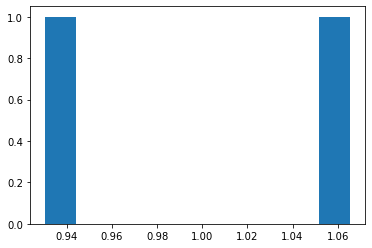

In [14]:
plt.hist(sigma_diff)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fit value: mu = 9.62089 +/- 12.93402
Fit value: sigma = 3.78240 +/- 8.14383
Fit value: N = 127.61176 +/- 1325.70856
Chi2 value: 0.0   Ndof = -1    Prob(Chi2,Ndof) =   nan


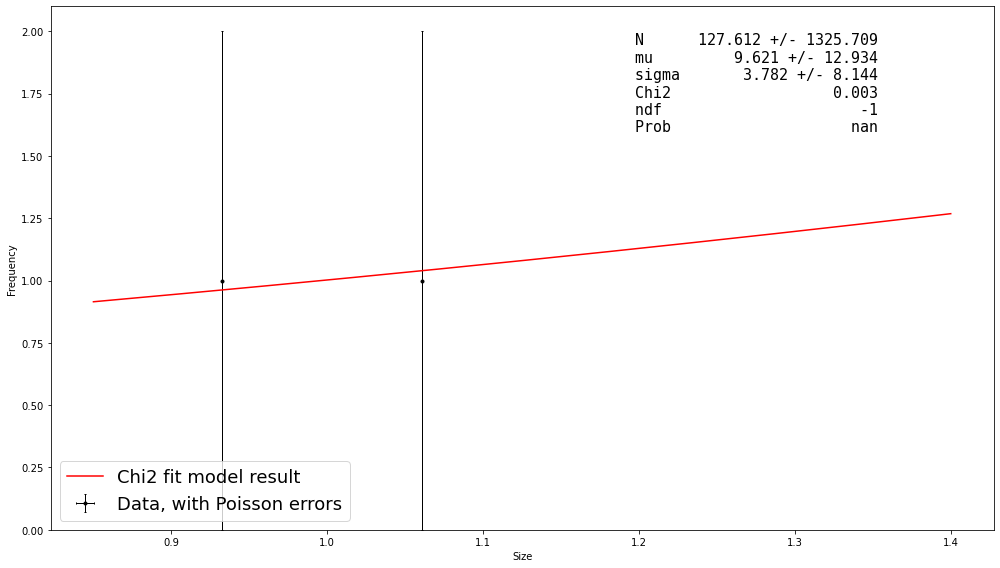

In [15]:
bin_and_fit_gauss(sigma_diff, "Sigma_diff_fit", 1.0, 0.1, 10, 30, 0.85, 1.4) 